# Electricity System Optimization

1. **Single-Year Optimization** - Minimize generation and upgrade costs for one year

In [58]:

#Input data we are making a electricity system with 3 generators and 3 demands and 8 buses in total
#they should not be slack buses
buses = {
    'Bus1': {'type': 'generator'},
    'Bus2': {'type': 'generator'},
    'Bus3': {'type': 'generator'},
    'Bus4': {'type': 'generator'},
    'Bus5': {'type': 'load'},
    'Bus6': {'type': 'generator'},
    'Bus7': {'type': 'load'},
    'Bus8': {'type': 'load'},
}
generators = {
    'Gen1': {'bus': 'Bus1', 'capacity': 300, 'cost': 20},
    'Gen2': {'bus': 'Bus2', 'capacity': 150, 'cost': 10},
    'Gen3': {'bus': 'Bus3', 'capacity': 600, 'cost': 30},
    'Gen4': {'bus': 'Bus4', 'capacity': 0, 'cost': 0},
    'Gen5': {'bus': 'Bus6', 'capacity': 0, 'cost': 0},
}
loads = {
    'Load5': {'bus': 'Bus5', 'demand': 80},
    'Load7': {'bus': 'Bus7', 'demand': 120},
    'Load8': {'bus': 'Bus8', 'demand': 150},
}
lines = {
    ('Bus1', 'Bus4'): {'capacity': 50},
    ('Bus1', 'Bus2'): {'capacity': 50},
    ('Bus2', 'Bus3'): {'capacity': 70},
    ('Bus2', 'Bus5'): {'capacity': 50},
    ('Bus3', 'Bus6'): {'capacity': 90},
    ('Bus4', 'Bus7'): {'capacity': 80},
    ('Bus5', 'Bus7'): {'capacity': 70},    
    ('Bus5', 'Bus6'): {'capacity': 65},
    ('Bus6', 'Bus8'): {'capacity': 50},  
    ('Bus7', 'Bus8'): {'capacity': 30},
}  
#Cost for increasing line capacities
line_upgrade_cost = 5  # Cost per unit increase in line capacity 



## Input Data

Defining the network topology, generators, loads, and transmission lines.

In [59]:
import gurobipy as gp
from gurobipy import GRB
# Create a new model
model = gp.Model("electricity_system")

# Create variables for generator outputs
gen_vars = {}
for gen, data in generators.items():
    gen_vars[gen] = model.addVar(lb=0, ub=data['capacity'], name=f"GenOutput_{gen}")

# Create variables for line flows and capacity upgrades (one per undirected line)
line_vars = {}
line_upgrade_vars = {}
for (bus_from, bus_to), data in lines.items():
    cap = data['capacity']
    # single flow var for the undirected line: allow negative values for reverse flow
    line_vars[(bus_from, bus_to)] = model.addVar(name=f"LineFlow_{bus_from}_{bus_to}")
    # single upgrade var (non-negative) for that same undirected line
    line_upgrade_vars[(bus_from, bus_to)] = model.addVar(name=f"LineUpgrade_{bus_from}_{bus_to}")

# Add capacity constraints: |flow| <= capacity + upgrade
for (bus_from, bus_to), data in lines.items():
    cap = data['capacity']
    f = line_vars[(bus_from, bus_to)]
    u = line_upgrade_vars[(bus_from, bus_to)]
    model.addConstr(f <= cap + u, name=f"CapPos_{bus_from}_{bus_to}")
    model.addConstr(f >= - (cap + u), name=f"CapNeg_{bus_from}_{bus_to}")

# Create constraints for power balance at each bus
for bus, data in buses.items():
    inflow = gp.LinExpr()
    outflow = gp.LinExpr()
    generation = gp.LinExpr()
    demand = gp.LinExpr()
    
    # Sum inflows and outflows from lines
    for (bus_from, bus_to), var in line_vars.items():
        if bus_to == bus:
            inflow += var
        if bus_from == bus:
            outflow += var
    
    # Sum generation at this bus
    for gen, gen_data in generators.items():
        if gen_data['bus'] == bus:
            generation += gen_vars[gen]
    
    # Sum demand at this bus
    for load, load_data in loads.items():
        if load_data['bus'] == bus:
            demand += load_data['demand']
    
    # Power balance constraint
    model.addConstr(generation + inflow == demand + outflow, name=f"PowerBalance_{bus}")
# Set objective: minimize generation cost and line upgrade cost
gen_cost = gp.quicksum(gen_vars[gen] * data['cost'] for gen, data in generators.items())
upgrade_cost = gp.quicksum(line_upgrade_vars[(bus_from, bus_to)] * line_upgrade_cost for (bus_from, bus_to) in lines.keys())
model.setObjective(gen_cost + upgrade_cost, GRB.MINIMIZE)
# Optimize the model
model.optimize()
# Print the results
if model.status == GRB.OPTIMAL: 
    #Print the cost of line capacity upgrades
    print("Line capacity upgrade cost results:")
    for (bus_from, bus_to), var in line_upgrade_vars.items():
        if var.x > 0:
            print(f"Upgrade on line {bus_from} to {bus_to}: {var.x} MW")
            

    print("\nOptimal Generation Outputs:")
    for gen, var in gen_vars.items():
        print(f"{gen}: {var.x} MW")
    
    print("\nOptimal Line Flows:")
    for (bus_from, bus_to), var in line_vars.items():
        print(f"Flow from {bus_from} to {bus_to}: {var.x} MW")
    
    print("\nLine Capacity Upgrades:")
    for (bus_from, bus_to), var in line_upgrade_vars.items():
        if var.x > 0:
            print(f"Upgrade on line {bus_from} to {bus_to}: {var.x} MW")
    
    print(f"\nTotal Cost: {model.objVal}")
    
    # Print the dual values of the power balance constraints
    print("\nDual Values of Power Balance Constraints:")
    for bus, data in buses.items():
        constr = model.getConstrByName(f"PowerBalance_{bus}")
        print(f"Bus {bus}: Dual Value = {constr.Pi}")   

    # Print the shadow prices for line capacity constraints
    print("\nShadow Prices for Line Capacity Constraints:")
    for (bus_from, bus_to), data in lines.items():
        constr_pos = model.getConstrByName(f"CapPos_{bus_from}_{bus_to}")
        constr_neg = model.getConstrByName(f"CapNeg_{bus_from}_{bus_to}")
        print(f"Line {bus_from} to {bus_to}: Shadow Price (Pos) = {constr_pos.Pi}, Shadow Price (Neg) = {constr_neg.Pi}")

    # Print dual variables for generation capacity constraints
    print("\nDual Variables for Generation Capacity Constraints:")
    for gen, data in generators.items():
        constr = model.getVarByName(f"GenOutput_{gen}")
        print(f"Generator {gen}: Dual Variable = {constr.SAobjLow}, {constr.SAobjUp}")

    # Print dual variables for line capacity upgrade constraints
    print("\nDual Variables for Line Capacity Upgrade Constraints:")
    for (bus_from, bus_to), data in lines.items():
        constr_pos = model.getConstrByName(f"CapPos_{bus_from}_{bus_to}")
        constr_neg = model.getConstrByName(f"CapNeg_{bus_from}_{bus_to}")
        print(f"Line {bus_from} to {bus_to}: Dual Variable (Pos) = {constr_pos.Pi}, Dual Variable (Neg) = {constr_neg.Pi}") 

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 28 rows, 25 columns and 65 nonzeros
Model fingerprint: 0x1b7b46dc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 3e+01]
  Bounds range     [2e+02, 6e+02]
  RHS range        [3e+01, 2e+02]
Presolve removed 15 rows and 7 columns
Presolve time: 0.03s
Presolved: 13 rows, 18 columns, 34 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5000000e+02   1.025000e+02   0.000000e+00      0s
       7    7.1000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.04 seconds (0.00 work units)
Optimal objective  7.100000000e+03
Line capacity upgrade cost results:
Upgrade on line Bus1 to Bus4: 100.0 MW
Upgrade on line Bus2 to Bus5: 80.0 MW
Upg

---

# Part 1: Single-Year Optimization

## Model Formulation and Solution

---

## Visualizations: Single-Year Results

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

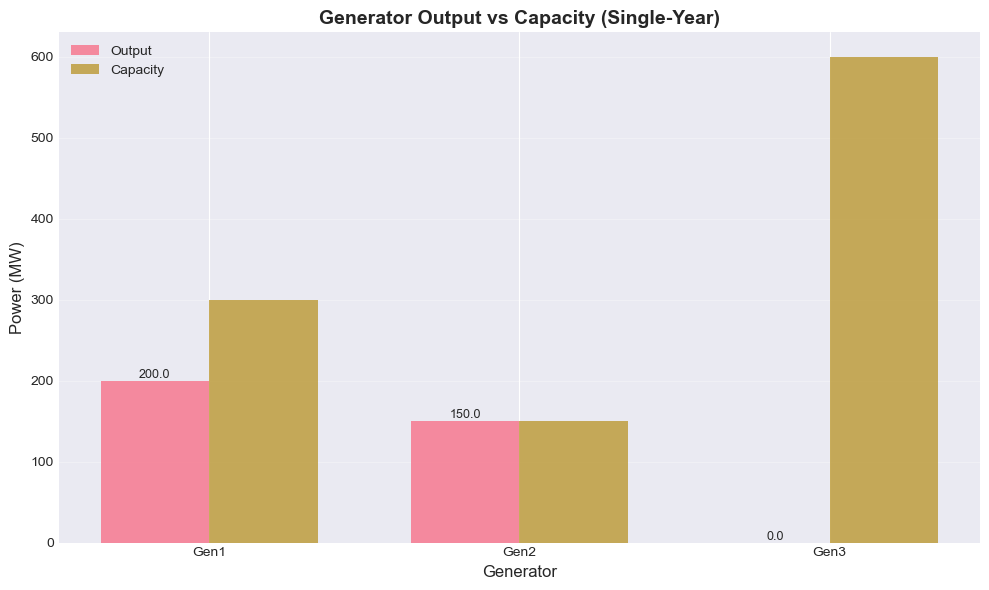

In [61]:
# 1. Generator Output vs Capacity Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Filter to only show generators with capacity > 0
active_gens = [gen for gen in gen_vars.keys() if generators[gen]['capacity'] > 0]
gen_outputs = [gen_vars[gen].x for gen in active_gens]
gen_capacities = [generators[gen]['capacity'] for gen in active_gens]

x = np.arange(len(active_gens))
width = 0.35

bars1 = ax.bar(x - width/2, gen_outputs, width, label='Output', alpha=0.8)
bars2 = ax.bar(x + width/2, gen_capacities, width, label='Capacity', alpha=0.8)

ax.set_xlabel('Generator', fontsize=12)
ax.set_ylabel('Power (MW)', fontsize=12)
ax.set_title('Generator Output vs Capacity (Single-Year)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(active_gens)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\victo\AppData\Local\Temp\ipykernel_19716\4270012004.py:73: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, [(bus_from, bus_to)], width=width,
C:\Users\victo\AppData\Local\Temp\ipykernel_19716\4270012004.py:73: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, [(bus_from, bus_to)], width=width,
C:\Users\victo\AppData\Local\Temp\ipykernel_19716\4270012004.py:73: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with

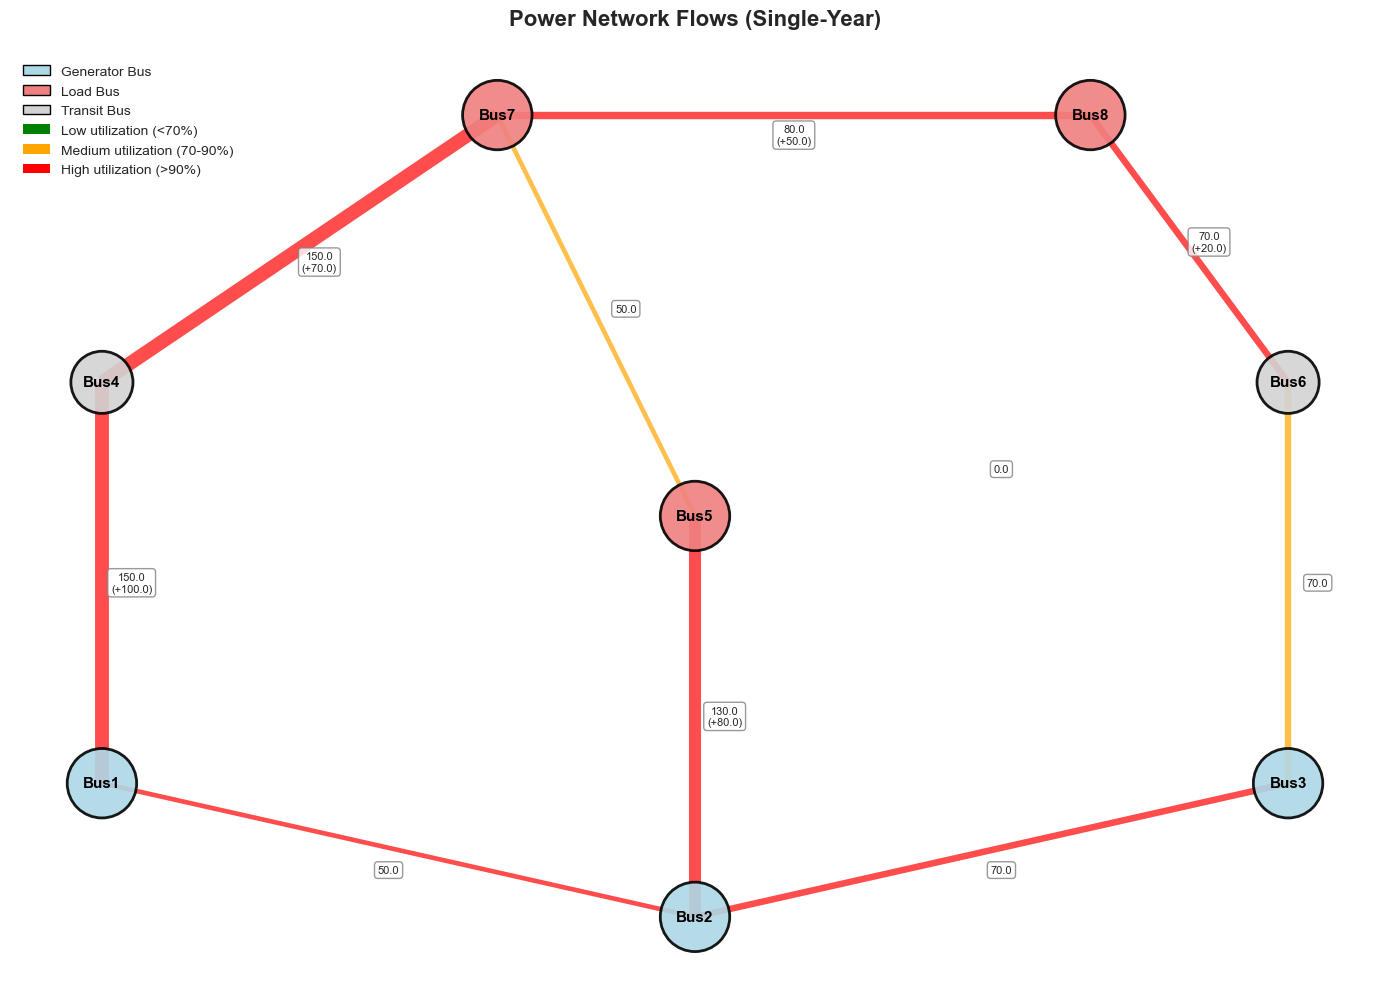

In [62]:
# 2. Network Diagram with Power Flows
fig, ax = plt.subplots(figsize=(14, 10))

# Create a graph with the actual line connections
G = nx.Graph()

# Add all buses as nodes
for bus in buses.keys():
    G.add_node(bus)

# Add edges based on actual line connections
for (bus_from, bus_to) in lines.keys():
    G.add_edge(bus_from, bus_to)

# Define positions for better visualization based on the network topology
# Layout arranged with generators at bottom (Bus1-3), loads at top (Bus7-8), transit buses in middle
pos = {
    'Bus1': (0, 0.5),      # Bottom left (Generator)
    'Bus2': (1.5, 0),      # Bottom center (Generator)
    'Bus3': (3, 0.5),      # Bottom right (Generator)
    'Bus4': (0, 2),        # Middle left (Transit)
    'Bus5': (1.5, 1.5),    # Middle center (Load)
    'Bus6': (3, 2),        # Middle right (Transit)
    'Bus7': (1, 3),        # Top left (Load)
    'Bus8': (2.5, 3)       # Top right (Load)
}

# Draw nodes with different colors for generators, loads, and transit buses
node_colors = []
node_sizes = []
for bus in G.nodes():
    # Check if bus has actual generation (capacity > 0)
    has_generation = any(gen_data['bus'] == bus and gen_data['capacity'] > 0 
                        for gen_data in generators.values())
    # Check if bus has actual load
    has_load = any(load_data['bus'] == bus for load_data in loads.values())
    
    if has_generation:
        node_colors.append('lightblue')  # Generator bus
        node_sizes.append(2500)
    elif has_load:
        node_colors.append('lightcoral')  # Load bus
        node_sizes.append(2500)
    else:
        node_colors.append('lightgray')  # Transit bus
        node_sizes.append(2000)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                       alpha=0.9, ax=ax, edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', ax=ax)

# Draw edges with thickness proportional to power flow
for (bus_from, bus_to), var in line_vars.items():
    flow = var.x
    capacity = lines[(bus_from, bus_to)]['capacity']
    upgrade = line_upgrade_vars[(bus_from, bus_to)].x
    
    # Edge width proportional to absolute flow
    width = max(1, abs(flow) / 15)
    
    # Color based on utilization
    utilization = abs(flow) / (capacity + upgrade) if (capacity + upgrade) > 0 else 0
    if utilization > 0.9:
        edge_color = 'red'
    elif utilization > 0.7:
        edge_color = 'orange'
    else:
        edge_color = 'green'
    
    # Draw arrow in direction of flow
    if abs(flow) > 0.1:  # Only draw if there's significant flow
        if flow > 0:
            nx.draw_networkx_edges(G, pos, [(bus_from, bus_to)], width=width, 
                                  edge_color=edge_color, alpha=0.7, 
                                  arrowsize=20, arrowstyle='->', ax=ax,
                                  connectionstyle='arc3,rad=0.1')
        else:
            nx.draw_networkx_edges(G, pos, [(bus_to, bus_from)], width=width, 
                                  edge_color=edge_color, alpha=0.7, 
                                  arrowsize=20, arrowstyle='->', ax=ax,
                                  connectionstyle='arc3,rad=0.1')
    
    # Add edge labels with flow values
    mid_x = (pos[bus_from][0] + pos[bus_to][0]) / 2
    mid_y = (pos[bus_from][1] + pos[bus_to][1]) / 2
    
    # Add small offset for readability
    offset_x = (pos[bus_to][1] - pos[bus_from][1]) * 0.05
    offset_y = -(pos[bus_to][0] - pos[bus_from][0]) * 0.05
    
    label_text = f'{abs(flow):.1f}'
    if upgrade > 0.1:
        label_text += f'\n(+{upgrade:.1f})'
    
    ax.text(mid_x + offset_x, mid_y + offset_y, label_text, 
            fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))

ax.set_title('Power Network Flows (Single-Year)', fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', edgecolor='black', label='Generator Bus'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Load Bus'),
    Patch(facecolor='lightgray', edgecolor='black', label='Transit Bus'),
    Patch(facecolor='green', label='Low utilization (<70%)'),
    Patch(facecolor='orange', label='Medium utilization (70-90%)'),
    Patch(facecolor='red', label='High utilization (>90%)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

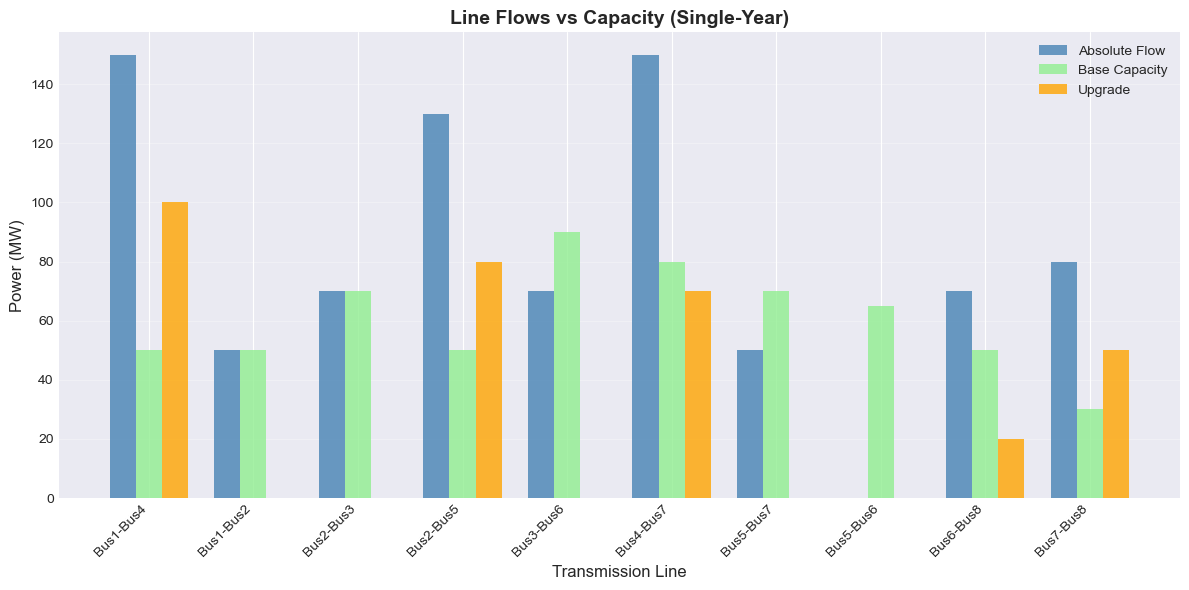

In [63]:
# 3. Line Flows vs Capacity (with Upgrades)
fig, ax = plt.subplots(figsize=(12, 6))

line_names = [f"{bf}-{bt}" for (bf, bt) in lines.keys()]
flows = [abs(line_vars[(bf, bt)].x) for (bf, bt) in lines.keys()]
base_caps = [lines[(bf, bt)]['capacity'] for (bf, bt) in lines.keys()]
upgrades = [line_upgrade_vars[(bf, bt)].x for (bf, bt) in lines.keys()]
total_caps = [base_caps[i] + upgrades[i] for i in range(len(base_caps))]

x = np.arange(len(line_names))
width = 0.25

bars1 = ax.bar(x - width, flows, width, label='Absolute Flow', alpha=0.8, color='steelblue')
bars2 = ax.bar(x, base_caps, width, label='Base Capacity', alpha=0.8, color='lightgreen')
bars3 = ax.bar(x + width, upgrades, width, label='Upgrade', alpha=0.8, color='orange')

ax.set_xlabel('Transmission Line', fontsize=12)
ax.set_ylabel('Power (MW)', fontsize=12)
ax.set_title('Line Flows vs Capacity (Single-Year)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(line_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

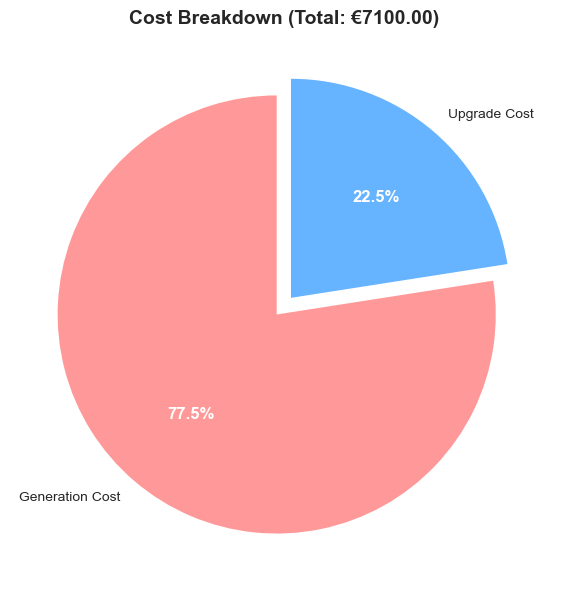

In [64]:
# 4. Cost Breakdown Pie Chart
total_gen_cost = sum(gen_vars[gen].x * generators[gen]['cost'] for gen in generators.keys())
total_upgrade_cost = sum(line_upgrade_vars[(bf, bt)].x * line_upgrade_cost for (bf, bt) in lines.keys())

fig, ax = plt.subplots(figsize=(8, 6))
costs = [total_gen_cost, total_upgrade_cost]
labels = ['Generation Cost', 'Upgrade Cost']
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0.05)

wedges, texts, autotexts = ax.pie(costs, labels=labels, autopct='%1.1f%%',
                                    colors=colors, explode=explode, startangle=90)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

ax.set_title(f'Cost Breakdown (Total: €{model.objVal:.2f})', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()